# Toy Notebook
## Examples & Function calls

In [1]:
#Import python + plotting packages
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

In [2]:
#Import packages from framework

#basic package to run simulation
import py.continuum1d as continuum1d

#package to individually set parameters
from py.params import setParams

#parameters to compute fixed-point values & their stability
from py.analysis import computeFPs, checkFixPtsStability

#functions to identify type of violation (a_jkValues necessary for violation-call)
#lmbd returns a list of eigenvalues w.r.t. changing wavenumber k
from py.analysis import violationType, a_jkValues, lmbd

#functions that help visualisations of analyses (nullclines, transfer functions, determinant, trace)
from py.analysis import activity_ui, activity_ue, det, tr, F_e, F_i

#import plotting-template - this is NOT necesssary, in this exmple, it's to simplify visualisations
#decomment this line, if you do not have the template available
path = '/Users/ronja/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/'
plt.style.use(path + 'template.mplstyle')

## run simulations - random initialisation
activity-based, integration via fourier-transform, without adaptation

In [3]:
c1d = continuum1d.continuum1d()

1d Model initialised.


In [4]:
Ie = 0.0
Ii = -0.72
params={'I_e': Ie, 'I_i': Ii}
params=setParams(params)

In [5]:
ue, ui = c1d.run(params, itype='inte_fft') #'inte_adaptation' does the same, if b=0.

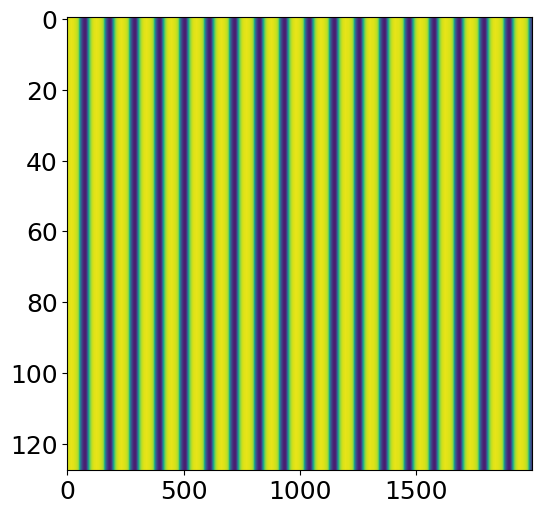

In [6]:
plt.figure(figsize=(6,6))

plt.imshow(ue.T[:,-2000:], vmin=0, vmax=1, aspect='auto')

## run simulation - initialisation around fixed point
fixed point of uncoupled system is used for initialisation.

In [7]:
#compute fp-values of uncoupled system.
fps = computeFPs(params)

#per fp, identify the stability in the uncoupled system
stab = checkFixPtsStability(fps, params)

print('for the fixed points %s, we have the corresponding stability %s (1=stable, 0=unstable)' %(str(fps), str(stab)))

for the fixed points [[0.33781536 0.46754544]], we have the corresponding stability [0] (1=stable, 0=unstable)


In [8]:
#choose the fixed point for initialisation
fp = fps[0]

In [9]:
#run simulation init. around fp
ue_fp, ui_fp = c1d.run(params, itype='inte_fft', fp=fp)

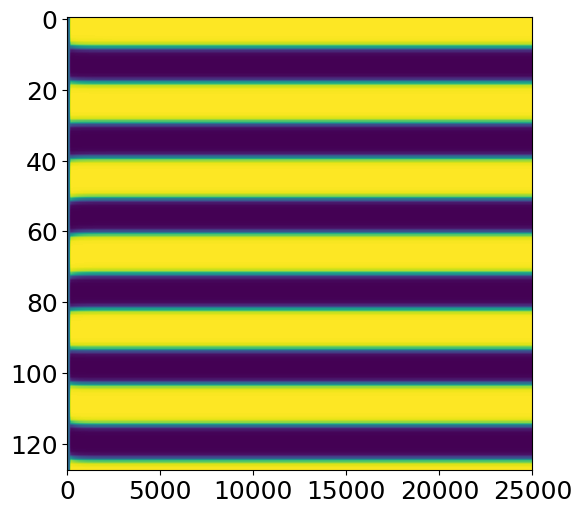

In [10]:
plt.figure(figsize=(6,6))

plt.imshow(ue_fp.T, vmin=0, vmax=1, aspect='auto')

# nullclines

In the following, we visualise the nullclines & how the activity of $u_e$ & $u_i$ evolve around it.
To do so, we use the fixed points & nullclines of the uncoupled system while we simulate activity in the coupled system. Since we use the fixed point values of the uncoupled system, the visualisation of the nullclines for this system is done.

Note: The Wilson-Cowan model without refractory stays $u_e,u_i\in[0,1]$, if $F(x)$ (transfer function) is chosen sigmoidal (which it is). Therefore, range $u_e$, $u_i$ in $[0,1]$ and plot the nullclines.

In [11]:
#input to range in [0,1]
inter = np.linspace(0, 1, 501)

#compute nullclines
ui_nc = activity_ui(inter, params)
ue_nc = activity_ue(inter, params)

/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return params.mu_e - (1/params.beta_e) * np.log((1/y)-1)
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:50: RuntimeWarning: divide by zero encountered in log
  return params.mu_e - (1/params.beta_e) * np.log((1/y)-1)
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return params.mu_i - (1/params.beta_i) * np.log((1/y)-1)
/Users/ronja/Documents/GitHub/neural-fields/py/analysis.py:53: RuntimeWarning: divide by zero encountered in log
  return params.mu_i - (1/params.beta_i) * np.log((1/y)-1)


Text(0.5, 1.0, 'Phase Plane')

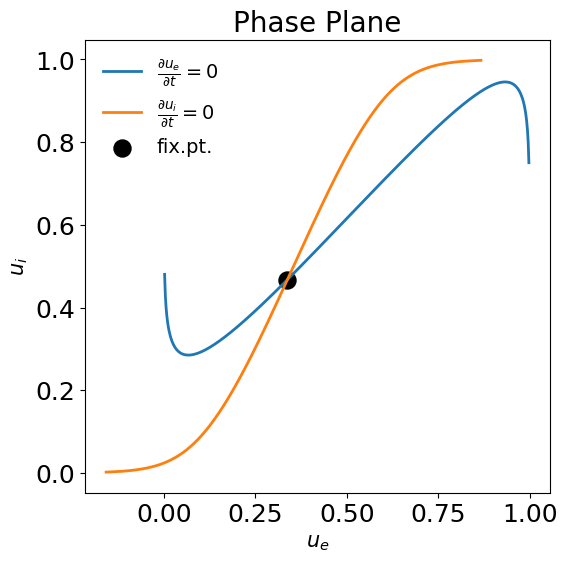

In [12]:
plt.figure(figsize=(6,6))


plt.plot(inter, ui_nc, label=r'$\frac{\partial u_e}{\partial t}=0$')
plt.plot(ue_nc, inter, label=r'$\frac{\partial u_i}{\partial t}=0$')
plt.scatter(fp[0], fp[1], s=150, label='fix.pt.', c='black')
plt.legend(fontsize=14)
plt.xlabel(r'$u_e$', fontsize=15)
plt.ylabel(r'$u_i$', fontsize=15)
plt.title('Phase Plane')

# activity around fixed point

Choose a random set of nodes along the ring and plot their activity over time in the phase plane

In [13]:
#random nodes
indeces = [24,38,89,110]

#choose which duration of the simulated activity you want to show
#I want to include how it evolves from the init. Therefore, starting point=timestep 0.
duration = [0, 2000] 

## randomly initialised

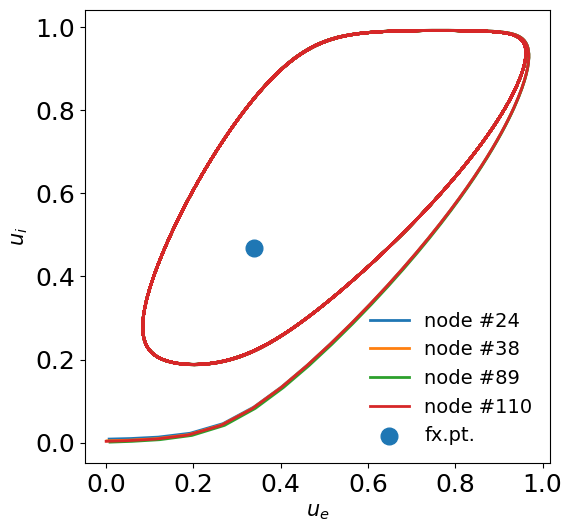

In [14]:
plt.figure(figsize=(6,6))

#cut activity of ue into duration-time
ue_plot = ue.T[:,int(duration[0]):int(duration[1])]
ui_plot = ui.T[:,int(duration[0]):int(duration[1])]

for idx in indeces:
    plt.plot(ue_plot[idx], ui_plot[idx], label='node #%i' %idx)
    
plt.scatter(fp[0], fp[1], label='fx.pt.')
plt.xlabel(r'$u_e$', fontsize=15)
plt.ylabel(r'$u_i$', fontsize=15)
plt.legend(fontsize=14)

## inisitalised around fixed point

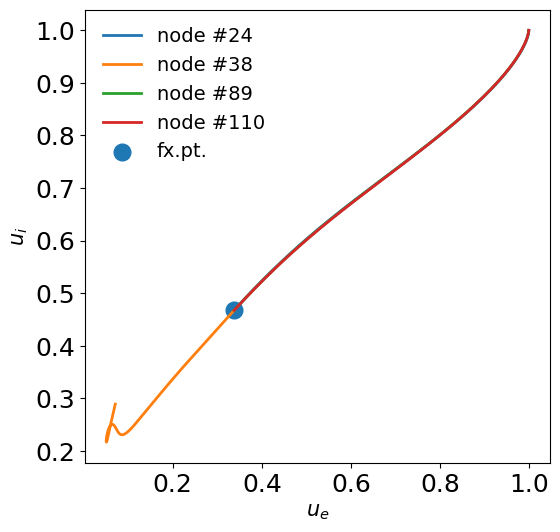

In [15]:
plt.figure(figsize=(6,6))

#cut activity of ue into duration-time
ue_plot_fp = ue_fp.T[:,int(duration[0]):int(duration[1])]
ui_plot_fp = ui_fp.T[:,int(duration[0]):int(duration[1])]

for idx in indeces:
    plt.plot(ue_plot_fp[idx], ui_plot_fp[idx], label='node #%i' %idx)
    
plt.scatter(fp[0], fp[1], label='fx.pt.')
plt.xlabel(r'$u_e$', fontsize=15)
plt.ylabel(r'$u_i$', fontsize=15)
plt.legend(fontsize=14)

# Kernel visualisations

The kernel values for the "looked at" length $l$ can be called via params - arrays contain then the values of $w(x)$ where $0\in[-\frac{l}{2}, \frac{l}{2}]$, and $x=[-\frac{l}{2}, \frac{l}{2}]$ with $x_{i+1}-x_i=dx$ and $dx$ is the integration space step (determined by $\frac{l}{n}$, where $n$ is the number of nodes on the ring).

Note: One has to shift the line ($\texttt{params.x}$) and the kernel values accordingly ($\texttt{params.ke, params.ki}$), since in the implementation, we have that $\texttt{x=np.array(}[0,...,\frac{l}{2}, -\frac{l}{2}, ...]\texttt{)}$ to be able to use the fourier transform for the integration (of the concolution in simulations). There we need that the "node to itself", i.e. the node with distance=0 to itself, appears first in the array.

In [16]:
#w_e(x)
exc_kernel = np.fft.fftshift(params.ke)
exc_kernel= np.roll(exc_kernel, -1)

#w_i(x)
inh_kernel = np.fft.fftshift(params.ki)
inh_kernel= np.roll(inh_kernel, -1)

#center space around zero instead of starting with 0
space = np.fft.fftshift(params.x)
space = np.roll(space, -1)

#investigate interaction by including connectivity weights 
#w_ee & w_ei (for exc population) and w_ie & w_ii (for inhibitory population)

exc_pop_kernel = params.w_ee*exc_kernel - params.w_ei*inh_kernel
inh_pop_kernel = params.w_ie*exc_kernel - params.w_ii*inh_kernel

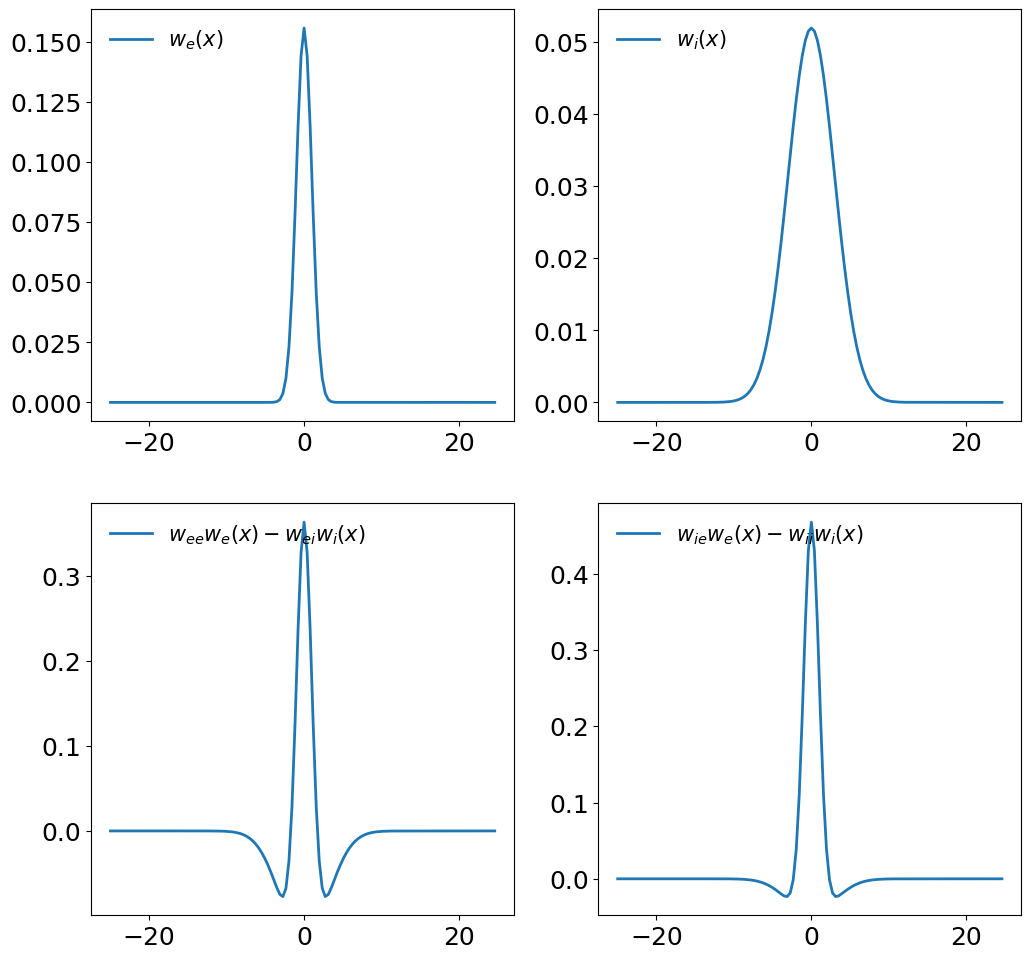

In [17]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12,12))

ax0.plot(space, exc_kernel, label=r'$w_e(x)$')
ax1.plot(space, inh_kernel, label=r'$w_i(x)$')
ax2.plot(space, exc_pop_kernel, label=r'$w_{ee}w_e(x)-w_{ei}w_i(x)$')
ax3.plot(space, inh_pop_kernel, label=r'$w_{ie}w_e(x)-w_{ii}w_i(x)$')

for ax in [ax0, ax1, ax2, ax3]:
    ax.legend(fontsize=15, loc = 'upper left')

# Investigation of the state space - default setting

Certain aspects of the analysis were already computed for the default setting. Therefore, one can call 'default.csv' to import the pandas-dataframe the contains the information/quantities which were already determined. State space for $(I_e, I_i)\in[-1,1]^2$.

In [18]:
df = pd.read_csv('csv/default.csv')

In [19]:
#function call for plotting - to simplify things

def setAxes(df, nmb):
    
    # Add minorticks on the colorbar to make it easy to read the
    # values off the colorbar.
    
    nmb_labels = 5
                
    idx_x = np.linspace(0,len(df.columns.values)-1, nmb_labels).astype(int)
    idx_y = np.linspace(0,len(df.index.values)-1, nmb_labels).astype(int)
        
    xliste= np.round(df.columns.values, decimals=2)[idx_x]
    yliste= np.round(df.index.values, decimals=2)[idx_y]
    
    #xliste = np.linspace(xaxis[0],xaxis[-1],nmb_labels)
    #yliste = np.linspace(yaxis[-1],yaxis[0],nmb_labels)
    
    xlabels=list('%.1f'%(e) for e in xliste)
    ylabels=list('%.1f'%(e) for e in yliste)
    
    return xlabels, ylabels

def plotDiscreteMap(df, xaxis='I_e', yaxis='I_i', scatter=False,
                    title='State space for default values', colorbar=True):
    
    p_colors = cm.get_cmap('Accent', 4)
    
    stabis = df.pivot_table('stability', columns=xaxis, index=yaxis)
    turings = df.pivot_table('turing', columns=xaxis, index=yaxis)
    p_randoms = df.pivot_table('p_random', columns=xaxis, index=yaxis)
    p_downs = df.pivot_table('p_down', columns=xaxis, index=yaxis) #kommentiere diese zeile aus, falls multistabi nicht erhoben wird
    compare = p_randoms.eq(p_downs) #kommentiere diese zeile aus, falls multistabi nicht erhoben wird
    
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    
    
    
    nmb_labels = 5
                
    xlabels, ylabels = setAxes(stabis, nmb_labels)
    
    pos = ax.imshow(stabis, origin='lower', vmin=1, vmax=4, aspect='auto', cmap='gist_gray')#cmap=p_colors) #
    pos = ax.imshow(p_randoms, origin='lower', vmin=1, vmax=4, aspect='auto', cmap=p_colors) #
    ax.contour(stabis, origin='lower', vmin=0, vmax=2, levels=1, cmap='YlGnBu')
    ax.contour(turings, origin='lower', vmin=0, vmax=1, levels=0, cmap='RdGy', 
               linestyles='dashed')
    ax.contour(compare, origin='lower', vmin=0, vmax=1, levels=0, colors='darkviolet', 
               linestyles='dotted') #kommentiere diese zeile aus, falls multistabi nicht erhoben wird
    
    
    ax.set(title=title)
    
    
    
    if scatter:
        scatter0 = stabis.columns.values.flat[np.abs(stabis.columns.values - scatter[0]).argmin()]#findNearest(stabis.index.values, scatter[0])
        scatter1 = stabis.index.values.flat[np.abs(stabis.index.values - scatter[1]).argmin()] #findNearest(stabis.index.values, scatter[1])
        xnodes = np.linspace(0, len(stabis.columns.values)-1, len(stabis.columns.values))
        ynodes = np.linspace(0, len(stabis.index.values)-1, len(stabis.index.values))
        ax.scatter(xnodes[list(stabis.columns.values).index(scatter0)], ynodes[list(stabis.index.values).index(scatter1)], s=150, c='yellow', marker='*', zorder=2) 
        
    # Add minorticks on the colorbar to make it easy to read the
    # values off the colorbar.
    
    ax.xaxis.set_major_locator(ticker.LinearLocator(nmb_labels))
    ax.set_xticklabels(labels=xlabels)
    ax.yaxis.set_major_locator(ticker.LinearLocator(nmb_labels))
    ax.set_yticklabels(labels=ylabels)
    
    ax.set_xlabel(r'$%s$' %xaxis)
    ax.set_ylabel(r'$%s$' %yaxis, labelpad=10, rotation=0)
    
    ax.label_outer()
    
    mini = 1
    maxi = 4
    cbar_ticks=np.linspace(mini,maxi,4)
    cbar_ticks=np.around(cbar_ticks, decimals=0)
    cbar_labels=['stat', 'temp', 'spat', 'spatiotemp']
    
    if colorbar:
        # Create colorbar
        cb_ax = fig.add_axes([.93,.126,.04,.754])
        cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
        cbar.ax.set_ylabel('pattern-type', rotation=-90, va="bottom")
        cbar.ax.set_yticklabels(cbar_labels, rotation=-90)
        
        
        cbar.minorticks_on()
        
    
        
#    plt.legend(loc='lower right')
    
    
    
    plt.show()

Set $\texttt{scatter=[I_e, I_i]}$ to position a star-marker on the position you're interested in, e.g. if you want to take look at a certain parametrization for which you have both bistability in the uncoupled system, but Turing instability in the down-state (as below)

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/838143870.py:46: UserWarning: No contour levels were found within the data range.
  ax.contour(turings, origin='lower', vmin=0, vmax=1, levels=0, cmap='RdGy',
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/838143870.py:48: UserWarning: No contour levels were found within the data range.
  ax.contour(compare, origin='lower', vmin=0, vmax=1, levels=0, colors='darkviolet',
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/838143870.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xlabels)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/838143870.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ylabels)


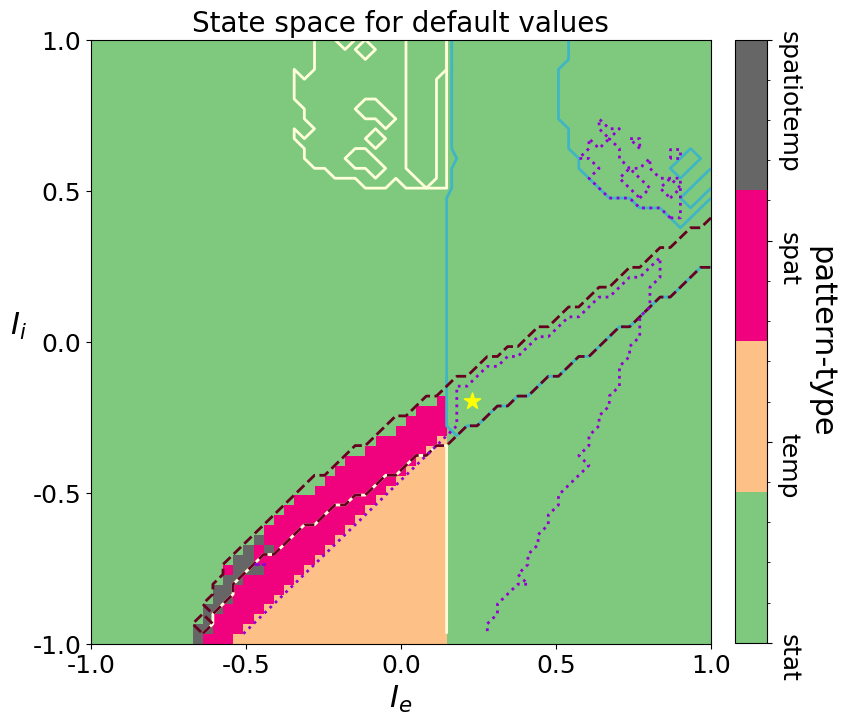

In [20]:
Ie= 0.25
Ii= -0.2

plotDiscreteMap(df, scatter=[Ie, Ii])

# Visualise violation type

A stable fixed point of the uncoupled system can undergo "different types of bifurcations" ("lose stability"), which is detectable by an extended analysis (i.e. pattern formation in the coupled system by identification of Turing-/Turing-Hopf instability). For approaches, see either Harris & Ermentrout 'Traveling waves in a spatially-distributed Wilson–Cowan model of cortex: From fronts to pulses' (2018), or Wyller et al 'Turing instability and pattern formation in a two-population neuronal network model' (2007).

We will use the above chosen setting (yellow star in state space).

Note: We have to determine the violation type for each fixed point. For the chosen setting, we have 3 fixed points $\Rightarrow$ do the same 3 times.

In [21]:
params = {'I_e': Ie, 'I_i': Ii}

params = setParams(params)

#compute fp-values of uncoupled system.
fps = computeFPs(params)

#per fp, identify the stability in the uncoupled system
stab = checkFixPtsStability(fps, params)

print('for the fixed points %s, we have the corresponding stability %s (1=stable, 0=unstable)' %(str(fps), str(stab)))

for the fixed points [[0.15382926 0.41662662]
 [0.83594413 0.9997501 ]
 [0.98105733 0.99997717]], we have the corresponding stability [1, 0, 1] (1=stable, 0=unstable)


## We can have 4 Options of violation:
1. no violation $\Rightarrow\ \texttt{vio=0}$, fixed point 'remains' stable.
2. det(A(k)) > 0 violated for $\texttt{k0}\neq0,\ \Rightarrow\ \texttt{vio=1}$, fixed point undergoes a static Turing-bifurcation point. We call it "Turing unstable".
3. tr(A(k)) < violated for $\texttt{k0}\neq0,\ \Rightarrow\ \texttt{vio=2}$, fixed point undergoes a dynamic Turing-bifurcation point.
4. Both 2. & 3. are violated $\Rightarrow\ \texttt{vio=3}$.

Note: Identification of violation-type through det-tr only works as long as we are in a 2D dynamical system (diemsnion refers to system-dimension, NOT space x).

In [22]:
#set the range for increasing wavenumber k
k = np.linspace(-3,3,501)

In [23]:
#downstate:
fp = fps[0]

#determine a_jk values for determinant & trace
a_ee, a_ei, a_ie, a_ii = a_jkValues(fp, params)

#determine the type of violation
vio, k0 = violationType(k, a_ee, a_ei, a_ie, a_ii, params)

print('for fixed point (u_e, u_i)=%s, we have violation %i' %(str(fp), int(vio)))

#to later visualise what the violations means, compute det(A(k)) & tr(A(k)) for each fp
det0 = det(k, a_ee, a_ei, a_ie, a_ii, params)
tr0 = tr(k, a_ee, a_ii, params)

#again for visualisation reasons: let the simulation run, init. around fp:
ue0, ui0 = c1d.run(params, itype = 'inte_fft', fp=fp)

for fixed point (u_e, u_i)=[0.15382926 0.41662662], we have violation 1


In [24]:
#saddle node:
fp = fps[1]

#determine a_jk values for determinant & trace
a_ee, a_ei, a_ie, a_ii = a_jkValues(fp, params)

#fp[1] is the saddle node and not stable to begin with => no identification of violation type.

#to later visualise what the violations means, compute det(A(k)) & tr(A(k)) for each fp
det1 = det(k, a_ee, a_ei, a_ie, a_ii, params)
tr1 = tr(k, a_ee, a_ii, params)

#again for visualisation reasons: let the simulation run, init. around fp:
ue1, ui1 = c1d.run(params, itype = 'inte_fft', fp=fp)

In [25]:
#upstate:
fp = fps[2]

#determine a_jk values for determinant & trace
a_ee, a_ei, a_ie, a_ii = a_jkValues(fp, params)

#determine the type of violation
vio, k0 = violationType(k, a_ee, a_ei, a_ie, a_ii, params)

print('for fixed point (u_e, u_i)=%s, we have violation %i' %(str(fp), int(vio)))

#to later visualise what the violations means, compute det(A(k)) & tr(A(k)) for each fp
det2 = det(k, a_ee, a_ei, a_ie, a_ii, params)
tr2 = tr(k, a_ee, a_ii, params)

#again for visualisation reasons: let the simulation run, init. around fp:
ue2, ui2 = c1d.run(params, itype = 'inte_fft', fp=fp)

for fixed point (u_e, u_i)=[0.98105733 0.99997717], we have violation 0


/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/577977390.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=time_labels)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/577977390.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=space_labels)


Text(0, 0.5, 'space')

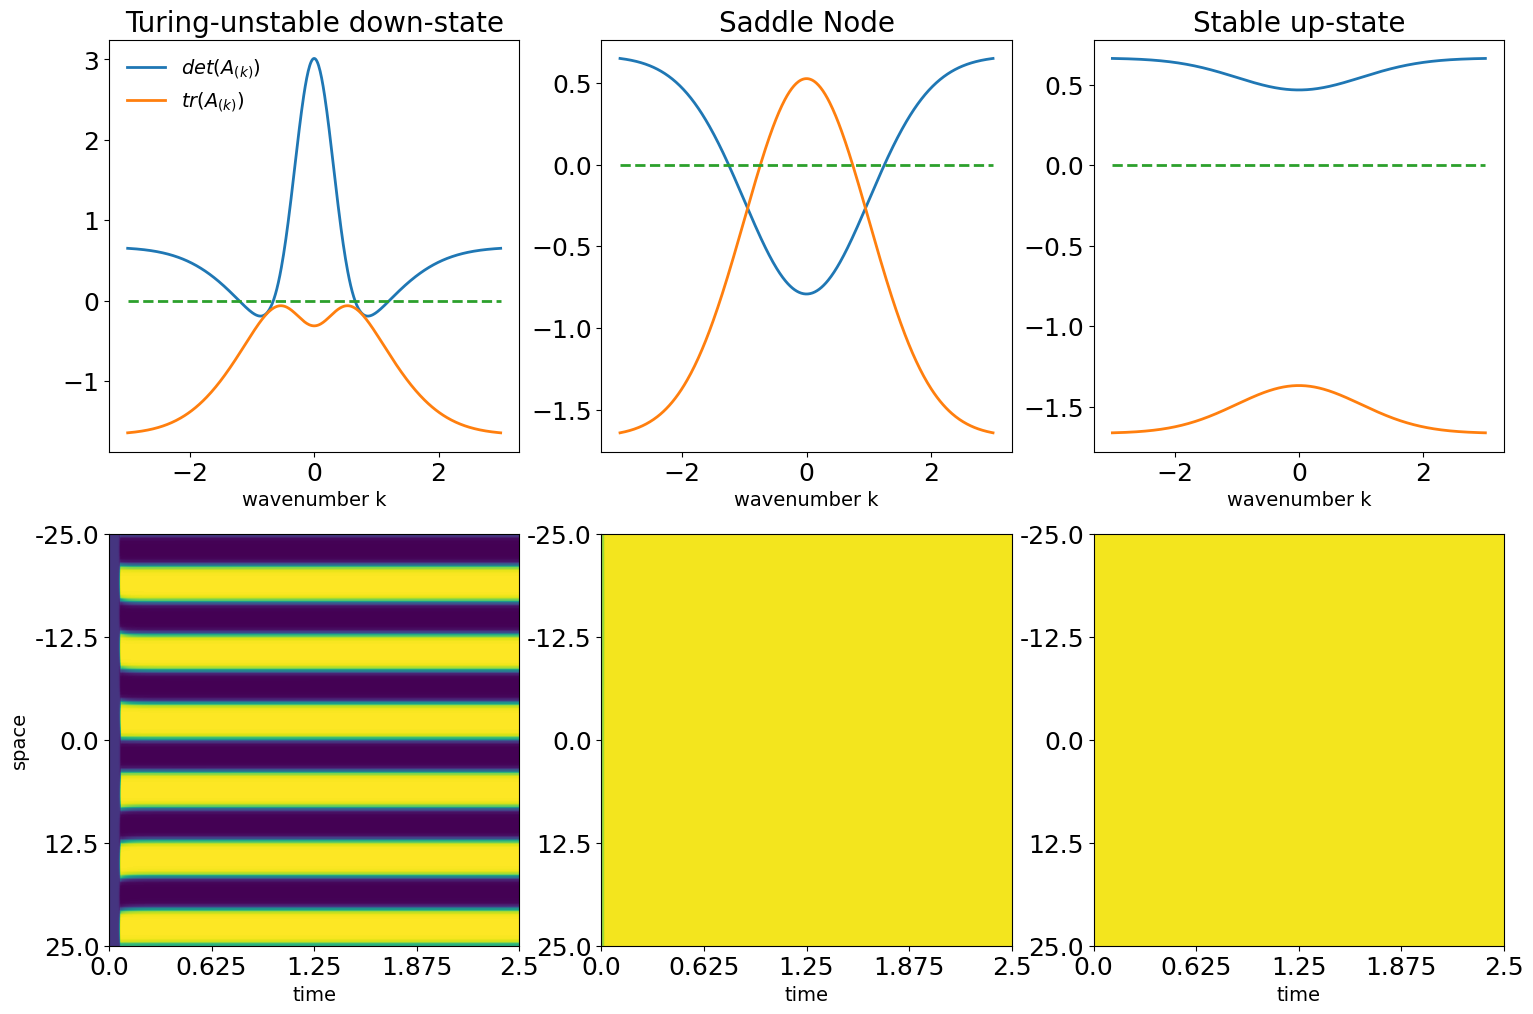

In [26]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(18,12))

zero_line = np.linspace(0,0, len(k))

row1 = [ax0, ax1, ax2]
row2 = [ax3, ax4, ax5]
dets = [det0, det1, det2]
trs = [tr0, tr1, tr2]
ues = [ue0, ue1, ue2]

titles = ['Turing-unstable down-state', 'Saddle Node', 'Stable up-state']

for idx, ax in enumerate(row1):
    ax.plot(k, dets[idx], label=r'$det(A_{(k)})$')
    ax.plot(k, trs[idx], label=r'$tr(A_{(k)})$')
    ax.plot(k, zero_line, ls='dashed')
    ax.set_title(titles[idx])
    ax.set_xlabel('wavenumber k', fontsize=14)
    
ax0.legend(loc='upper left', fontsize=14)
    
time_labels = np.linspace(0,params.end_t*0.001,5)
space_labels = np.linspace(-params.length/2, params.length/2, 5)

for idx, ax in enumerate(row2):
    ax.imshow(ues[idx].T, vmin=0, vmax=1, aspect='auto')
    ax.set_xlabel('time', fontsize=14)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticklabels(labels=time_labels)
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_yticklabels(labels=space_labels)
    
ax3.set_ylabel('space', fontsize=14)
    

In the already named publication of Wyller et al (2007), they visualise the violation type in the $(\text{tr}, \det)$-plane, which they call the 'invariant plane'. The cases above then show the following.

Text(0, 0.5, 'det(A(k))')

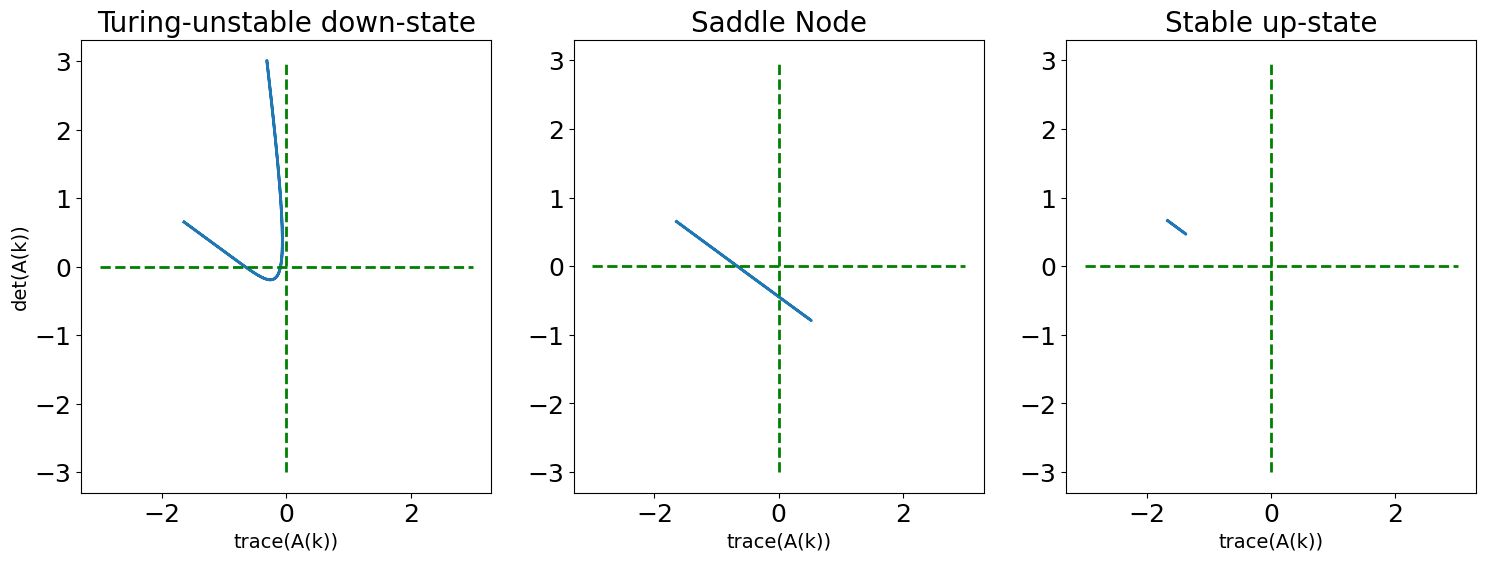

In [27]:
fig, row = plt.subplots(1, 3, figsize=(18,6))



for idx, ax in enumerate(row):
    ax.plot(trs[idx], dets[idx])
    ax.plot(k,zero_line, ls='dashed', c = 'green')
    ax.plot(zero_line, k, ls='dashed', c = 'green')
    ax.set_title(titles[idx])
    ax.set_xlabel('trace(A(k))', fontsize=14)

row[0].set_ylabel('det(A(k))', fontsize=14)

# Quantitiative properties

This is a first approach to gather information. In the following, we have determined the frequency for purly temporal patterns, and the number of bumps, as well as the "size per bump" (relative to chosen visualisation space), for purly spatial patterns.

Note: For the default setting, these quantitites were already computed and can be called via $\texttt{pandas}$ into a dataframe from precomputed csv-files.

For the time-frequencies, we used the simulation-runs initialised randmly, for the bump-information, we used the simulation-runs init. around down-state fp.

[]

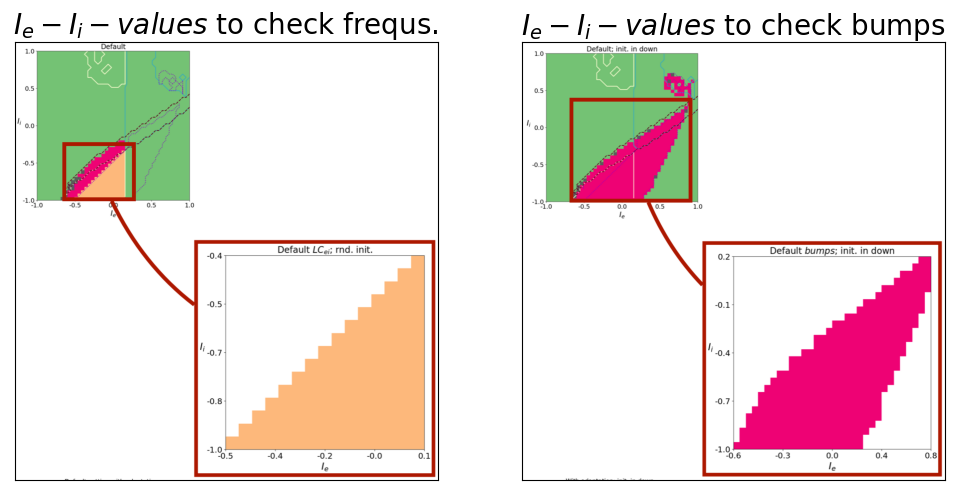

In [28]:
time_visu = plt.imread('times.png')
space_visu = plt.imread('spaces.png')

fig, (ax0, ax1) = plt.subplots(1,2, figsize = (12,6))

ax0.imshow(time_visu)
ax0.set_title(r'$I_e-I_i-values$' + ' to check frequs.')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(space_visu)
ax1.set_title(r'$I_e-I_i-values$' + ' to check bumps')
ax1.set_xticks([])
ax1.set_yticks([])

# To-Do! Document, how they're computed. Further: write computing notebooks into py-script!!

In [29]:
time_frequs = pd.read_csv('default_temp_frequs.csv')
space_frequs = pd.read_csv('default_space_frequs.csv')


In [30]:
#restrict dataframe to ranges shown in images above - this is only done for visualisation-reasons
#temporal
time_frequs = time_frequs[time_frequs['I_e']>=-1]
time_frequs = time_frequs[time_frequs['I_e']<=1]
time_frequs = time_frequs[time_frequs['I_i']>=-1]
time_frequs = time_frequs[time_frequs['I_i']<=1]

#spatial
space_frequs = space_frequs[space_frequs['I_e']>=-1]
space_frequs = space_frequs[space_frequs['I_e']<=0.8]
space_frequs = space_frequs[space_frequs['I_i']>=-1]
space_frequs = space_frequs[space_frequs['I_i']<=0.4]

In [34]:
def plotMap(df, xaxis='I_e', yaxis='I_i', scatter=False,
                    title='Dominant frequencies', colorbar=True,
                   plotty = 'dom_frequ', colorbar_title = 'dominant frequ.'):
    
    p_colors = cm.get_cmap('Accent', 4)
    
    plots = df.pivot_table(plotty, columns=xaxis, index=yaxis)
    
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    nmb_labels = 5
                
    xlabels, ylabels = setAxes(plots, nmb_labels)
    
    vals=df[plotty].to_numpy()
    mini = min(vals)
    if any(np.isinf(vals)):
        maxi=20
    else:
        maxi = max(vals)
    
    pos = ax.imshow(plots, origin='lower', vmin=mini, vmax=maxi, aspect='auto', cmap='viridis')
    
    ax.set(title=title)
     
    # Add minorticks on the colorbar to make it easy to read the
    # values off the colorbar.
    
    ax.xaxis.set_major_locator(ticker.LinearLocator(nmb_labels))
    ax.set_xticklabels(labels=xlabels)
    ax.yaxis.set_major_locator(ticker.LinearLocator(nmb_labels))
    ax.set_yticklabels(labels=ylabels)
    
    ax.set_xlabel(r'$%s$' %xaxis)
    ax.set_ylabel(r'$%s$' %yaxis, labelpad=10, rotation=0)
    
    ax.label_outer()
    
    cbar_ticks=np.linspace(mini,maxi,4)
    cbar_ticks=np.around(cbar_ticks, decimals=0)
    cbar_labels=['stat', 'temp', 'spat', 'spatiotemp']
    
    if colorbar:
        # Create colorbar
        cb_ax = fig.add_axes([.93,.126,.04,.754])
        cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
        cbar.ax.set_ylabel(colorbar_title, rotation=-90, va="bottom")
   #     cbar.ax.set_yticklabels(cbar_labels, rotation=-90)
        
        
        cbar.minorticks_on()
        
    
        
#    plt.legend(loc='lower right')
    
    
    
    plt.show()

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/951972036.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xlabels)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/951972036.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ylabels)


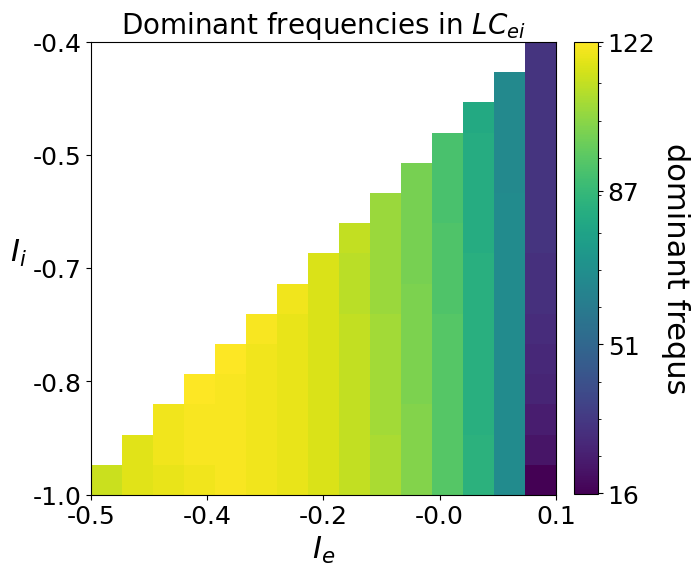

In [35]:
plotMap(time_frequs, title='Dominant frequencies in ' + r'$LC_{ei}$', 
                plotty='dom_frequ', colorbar = True, colorbar_title='dominant frequs')

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/951972036.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xlabels)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3601/951972036.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ylabels)


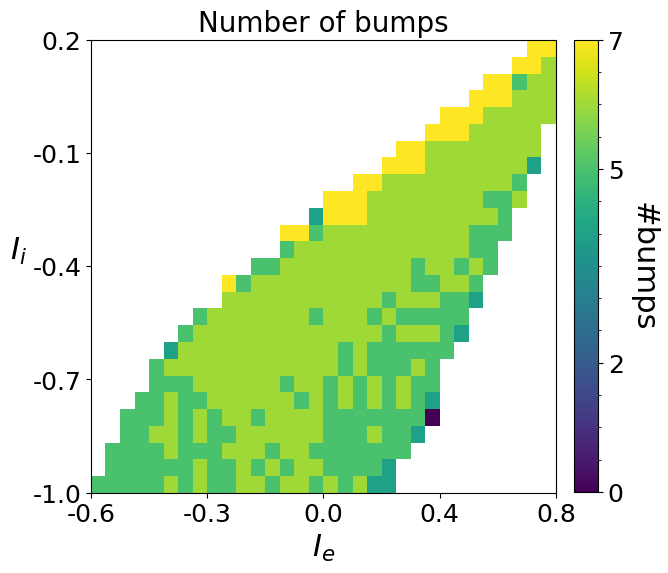

In [36]:
#use plotting function from above
plotMap(space_frequs, title='Number of bumps', 
        plotty='dom_frequ', colorbar = True, colorbar_title='#bumps')

In the dataframes are also computed values of "up-/down-state duration" and "size of up-/down-state bump". These can aso be visualised with the help of the function $\texttt{plotMap}$ from above. One only has to change the variable that calls the quantity. In the function, use 'plotty' and change it for example to 'up_duration'.

If one isn't sure, what the dataframe entries are called, simply call the dataframe of interest in the next line and look at the column-names.

In [37]:
#time_frequs